In [1]:
import json
from watson_developer_cloud import ToneAnalyzerV3
import numpy as np
import pandas as pd
import seaborn as sns
# import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

In [2]:
tone_analyzer = ToneAnalyzerV3(
    version='2017-09-21',
    iam_apikey='X7XH0fw_2PNm--VtKGH2LVYWdiiqKvF9Rk54G2w-aohB',
    url='https://gateway.watsonplatform.net/tone-analyzer/api'
)


In [3]:
tone_analyzer = ToneAnalyzerV3(
    version = '2017-09-21',
    iam_apikey='jPlglAPDQPOICl423ZFhOwylugr4Avv0tUuxw44xqNqD',
    url='https://gateway.watsonplatform.net/tone-analyzer/api'
)

In [4]:
tone_analyzer.set_default_headers({'x-watson-learning-opt-out': "true"})

In [5]:
text = 'Team, I know that times are tough! Product '\
    'sales have been disappointing for the past three '\
    'quarters. We have a competitive product, but we '\
    'need to do a better job of selling it!'

tone_analysis = tone_analyzer.tone(
    {'text': text},
    'application/json'
).get_result()
print(json.dumps(tone_analysis, indent=2))

{
  "document_tone": {
    "tones": [
      {
        "score": 0.6165,
        "tone_id": "sadness",
        "tone_name": "Sadness"
      },
      {
        "score": 0.829888,
        "tone_id": "analytical",
        "tone_name": "Analytical"
      }
    ]
  },
  "sentences_tone": [
    {
      "sentence_id": 0,
      "text": "Team, I know that times are tough!",
      "tones": [
        {
          "score": 0.801827,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 1,
      "text": "Product sales have been disappointing for the past three quarters.",
      "tones": [
        {
          "score": 0.771241,
          "tone_id": "sadness",
          "tone_name": "Sadness"
        },
        {
          "score": 0.687768,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 2,
      "text": "We have a competitive product, but we need to do a bette

In [6]:
text1 = """
Wow Jeremy, you're so beautiful. Oh you're so egotistic huh? Esketit bois!!!!!!! I wanna die, everything hurts. Vegetables are so disgusting.
"""

tone_analysis1 = tone_analyzer.tone(
    {'text': text1},
    'application/json'
).get_result()
print(json.dumps(tone_analysis1, indent=2))

{
  "document_tone": {
    "tones": []
  },
  "sentences_tone": [
    {
      "sentence_id": 0,
      "text": "Wow Jeremy, you're so beautiful.",
      "tones": [
        {
          "score": 0.854215,
          "tone_id": "joy",
          "tone_name": "Joy"
        }
      ]
    },
    {
      "sentence_id": 1,
      "text": "Oh you're so egotistic huh?",
      "tones": []
    },
    {
      "sentence_id": 2,
      "text": "Esketit bois!!!!!!!",
      "tones": [
        {
          "score": 0.564467,
          "tone_id": "joy",
          "tone_name": "Joy"
        }
      ]
    },
    {
      "sentence_id": 3,
      "text": "I wanna die, everything hurts.",
      "tones": [
        {
          "score": 0.847245,
          "tone_id": "sadness",
          "tone_name": "Sadness"
        }
      ]
    },
    {
      "sentence_id": 4,
      "text": "Vegetables are so disgusting.",
      "tones": []
    }
  ]
}


In [7]:
def split_rows(response):
    for sentence in response['sentences_tone']:
        tones = sentence['tones']
        if tones:
            for tone in tones:
                yield {'sentence_id': sentence['sentence_id'],
                      'tone_id': tone['tone_id'],
                       'score': tone['score']}
        else:
            yield {'sentence_id': sentence['sentence_id'],
                      'tone_id': 'neutral',
                       'score': 1}
        

In [8]:
list(split_rows(tone_analysis))

[{'score': 0.801827, 'sentence_id': 0, 'tone_id': 'analytical'},
 {'score': 0.771241, 'sentence_id': 1, 'tone_id': 'sadness'},
 {'score': 0.687768, 'sentence_id': 1, 'tone_id': 'analytical'},
 {'score': 0.506763, 'sentence_id': 2, 'tone_id': 'analytical'}]

In [9]:
def response_to_df(response):
    return pd.DataFrame(split_rows(response))[['sentence_id', 'tone_id', 'score']]

In [10]:
df = response_to_df(tone_analysis)

In [11]:
df

,sentence_id,tone_id,score
0,0,analytical,0.801827
1,1,sadness,0.771241
2,1,analytical,0.687768
3,2,analytical,0.506763


(0.5, 1)

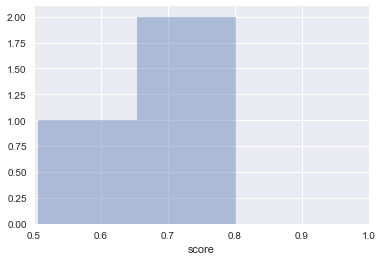

In [12]:
sns.distplot(df['score'][df['tone_id'] == 'analytical'], kde=False)
plt.xlim((0.5, 1))

In [13]:
def plot_distribution_of_scores(df):
    for tone in ('emotion', 'fear', 'joy', 'sadness', 'analytical', 'confident', 'tentative'):
        if tone in df['tone_id'].values:
            x = df['score'][df['tone_id'] == tone]
            data = [go.Histogram(x=x)]
            layout = go.Layout(
                title=tone,
                xaxis=dict(
                    title='Score'
                ),
                yaxis=dict(
                    title='Count'
                ),
                bargap=0.2,
                bargroupgap=0.1
            )
            fig = go.Figure(data=data, layout=layout)
            iplot(fig)

In [14]:
df

,sentence_id,tone_id,score
0,0,analytical,0.801827
1,1,sadness,0.771241
2,1,analytical,0.687768
3,2,analytical,0.506763


In [15]:
plot_distribution_of_scores(df)

In [16]:
def plot_proportion_of_sentences_with_emotion(df):
    x=['joy', 'confident', 'analytical', 'neutral', 'tentative', 'sadness', 'anger']
    data = [go.Bar(
                x = x,
                y=(df.groupby('tone_id')['score'].count()/(df['sentence_id'].values[-1] + 1)).loc[x].fillna(0),
                marker=dict(
                    color=['#47EC6C', '#A7C696',
                   '#C6B26D', '#CEC8B2',
                   '#EEBA91', '#E8796B', '#F4493B'])
                )
            ]
    layout = go.Layout(
                title="Proportion of Sentences With Tone",
                xaxis=dict(
                    title='Tone'
                ),
                yaxis=dict(
                    title='Proportion'
                ),
                bargap=0.2,
                bargroupgap=0.1
            )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [17]:
x = df.groupby('tone_id')

In [18]:
x.groups.keys()

dict_keys(['analytical', 'sadness'])

In [19]:
text3 = """
Hello Jeremy, I have a huge midterm coming up. My life is a mess right now. Cal Hacks is pretty fun though. This is a great experience. I am kind of hungry. It's a terrible sleeping environment. Why did you have to be so stupid? Who's idea was it to sleep here?? Hello Jeremy, I have a huge midterm coming up. My life is a mess right now. Cal Hacks is pretty fun though. This is a great experience. I am kind of hungry. It's a terrible sleeping environment. Why did you have to be so stupid? Who's idea was it to sleep here??
"""
tone_analysis3 = tone_analyzer.tone(
    {'text': text3},
    'application/json'
).get_result()

In [20]:
tone_analysis3

{'document_tone': {'tones': [{'score': 0.562712,
    'tone_id': 'joy',
    'tone_name': 'Joy'},
   {'score': 0.70865, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
 'sentences_tone': [{'sentence_id': 0,
   'text': 'Hello Jeremy, I have a huge midterm coming up.',
   'tones': []},
  {'sentence_id': 1,
   'text': 'My life is a mess right now.',
   'tones': [{'score': 0.50516,
     'tone_id': 'sadness',
     'tone_name': 'Sadness'}]},
  {'sentence_id': 2,
   'text': 'Cal Hacks is pretty fun though.',
   'tones': [{'score': 0.753173, 'tone_id': 'joy', 'tone_name': 'Joy'},
    {'score': 0.946222, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
  {'sentence_id': 3,
   'text': 'This is a great experience.',
   'tones': [{'score': 0.572197, 'tone_id': 'joy', 'tone_name': 'Joy'}]},
  {'sentence_id': 4,
   'text': 'I am kind of hungry.',
   'tones': [{'score': 0.59549, 'tone_id': 'anger', 'tone_name': 'Anger'},
    {'score': 0.968123, 'tone_id': 'tentative', 'tone_name': 'Tentative'}

In [21]:
df3 = response_to_df(tone_analysis3)

In [22]:
df3

,sentence_id,tone_id,score
0,0,neutral,1.000000
1,1,sadness,0.505160
2,2,joy,0.753173
3,2,tentative,0.946222
4,3,joy,0.572197
5,4,anger,0.595490
6,4,tentative,0.968123
7,5,sadness,0.566571
8,6,confident,0.866237
9,7,fear,0.557492


In [23]:
plot_distribution_of_scores(df3)

In [24]:
plot_proportion_of_sentences_with_emotion(df3)

In [25]:
df3

,sentence_id,tone_id,score
0,0,neutral,1.000000
1,1,sadness,0.505160
2,2,joy,0.753173
3,2,tentative,0.946222
4,3,joy,0.572197
5,4,anger,0.595490
6,4,tentative,0.968123
7,5,sadness,0.566571
8,6,confident,0.866237
9,7,fear,0.557492
